### Imports


In [1]:
# Autoreload modules
%load_ext autoreload
%autoreload 2

import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib import patches
from skimage.measure import regionprops
import numpy as np
import sys

# Import custom modules
src_dir = "../src"
sys.path.append(src_dir)

from utils.data import get_fashion_img_seg, get_random_voc_img, get_voc_img
from utils.draw import imshow_many, filter_color
from utils.draw import mask_to_3D, generate_palette
from utils.data_augmentation import voc_data_augmentation, crop_resize, log


classes = ('background', 'shirt, blouse', 'top, t-shirt, sweatshirt', 'sweater', 'cardigan', 'jacket', 
           'vest', 'pants', 'shorts', 'skirt', 'coat', 'dress', 'jumpsuit', 'cape', 'glasses', 'hat', 
           'headband, head covering, hair accessory', 'tie', 'glove', 'watch', 'belt', 'leg warmer', 
           'tights, stockings', 'sock', 'shoe', 'bag, wallet', 'scarf', 'umbrella', 'hood', 'collar', 
           'lapel', 'epaulette', 'sleeve', 'pocket', 'neckline', 'buckle', 'zipper', 'applique', 'bead', 
           'bow', 'flower', 'fringe', 'ribbon', 'rivet', 'ruffle', 'sequin', 'tassel')

palette = generate_palette(len(classes))

### Data directories


The `$voc_dir` (.VOCdevkit/VOC2012/) should have the following structure:
* Annotations
* ImageSets
* JPEGImages
* SegmentationClass
* SegmentationObject

BBox formats:
* COCO: [xmin, ymin, width, height]
* Pascal VOC: [xmin, ymin, xmax, ymax]

In [75]:
data_dir = '../../_data/'


# ======================================================================
# PASCAL VOC 2012 dataset
voc_dir= os.path.join(data_dir, 'VOCdevkit/VOC2012/')
annot_dir = os.path.join(voc_dir, 'Annotations/')

# Instance (object) and Semantic (class) Segmentation
voc_img_dir = os.path.join(voc_dir, 'JPEGImages/')

voc_ins_seg = voc_dir + "SegmentationObject/"
voc_sem_seg = voc_dir + "SegmentationClass/"

annot_files = os.listdir(annot_dir)
voc_classes = {'aeroplane': 0, 'bicycle': 1, 'bird': 2, 'boat': 3, 'bottle': 4, 'bus': 5, 'car': 6, 
               'cat': 7, 'chair': 8, 'cow': 9, 'diningtable': 10, 'dog': 11, 'horse': 12, 'motorbike': 13, 
               'person': 14, 'pottedplant': 15, 'sheep': 16, 'sofa': 17, 'train': 18, 'tvmonitor': 19}


# ======================================================================
# Fashionpedia dataset
fashion_dir = os.path.join(data_dir, 'fashionpedia-reduction/')
# fashion_dir = os.path.join(data_dir, 'fashionpedia/')

fashion_seg_dir = os.path.join(fashion_dir, "annotations/train/")
fashion_img_dir = os.path.join(fashion_dir, "train/")
# fashion_seg_dir = os.path.join(fashion_dir, "Annotations/mask_train/")
# fashion_seg_dir = os.path.join(fashion_dir, "Annotations/mask_train/")
# ======================================================================

print("VOC IMGs:", len(os.listdir(voc_img_dir)))
print("VOC Annotations:", len(annot_files))
print("VOC Instance seg.:", len(os.listdir(voc_ins_seg)), "=> warning! not all imgs have segmented imgs?")
print("VOC Semantic seg.:", len(os.listdir(voc_sem_seg)), "=> warning! not all imgs have segmented imgs?")
print("Fashionpedia imgs:", len(os.listdir(fashion_img_dir)))
print("Fashionpedia seg.:", len(os.listdir(fashion_seg_dir)))

# os.path.join(data_dir, f'fashionpedia-reduction/{train_or_val}/')

VOC IMGs: 17125
VOC Annotations: 17125
VOC Instance seg.: 2913 => warning! not all imgs have segmented imgs?
VOC Semantic seg.: 2913 => warning! not all imgs have segmented imgs?
Fashionpedia imgs: 26228
Fashionpedia seg.: 26227


In [150]:
# Fashionpedia dataset
indx = 1
train_or_val = ['train', 'val'][indx]
train_or_test = ['train', 'test'][indx]

fashion_dir = os.path.join(data_dir, 'fashionpedia-reduction/')
# fashion_dir = os.path.join(data_dir, 'fashionpedia/')

fashion_seg_dir = os.path.join(fashion_dir, f"annotations/{train_or_test}/")
fashion_img_dir = os.path.join(fashion_dir, train_or_val + "/")

print("Fashionpedia imgs:", len(os.listdir(fashion_img_dir)))
print("Fashionpedia seg.:", len(os.listdir(fashion_seg_dir)))

Fashionpedia imgs: 659
Fashionpedia seg.: 658


In [151]:
fashion_dir_daug = os.path.join(data_dir, 'fashionpedia-reduction-daug/')
fashion_seg_dir_daug = os.path.join(fashion_dir_daug, f"annotations/{train_or_test}/")
fashion_img_dir_daug = os.path.join(fashion_dir_daug, train_or_val + "/")

os.makedirs(fashion_dir_daug, exist_ok=True)
os.makedirs(fashion_img_dir_daug, exist_ok=True)
os.makedirs(fashion_seg_dir_daug, exist_ok=True)

In [153]:
counter = 0
for file in os.listdir(fashion_img_dir)[:]:
    img_id = file.split(".")[0]
    ext = file.split(".")[1]
    
    seg_file = os.path.join(fashion_seg_dir, img_id + "_seg.png")    
    
    if ext == "jpg":
        if not os.path.exists(seg_file):
            print(f"Missing: {seg_file}")
            print(ext)
            continue
        
        # Get the image and segmentation mask and apply data augmentation
        tar_img, tar_seg = get_fashion_img_seg(img_id, fashion_img_dir, fashion_seg_dir, plot=False)
        _,_,_,_, final_img, final_seg = voc_data_augmentation(tar_img, tar_seg, voc_img_dir, voc_ins_seg, cover_factor=0.6)
        
        # Create the new file names
        seg_file = os.path.join(fashion_seg_dir_daug, img_id + "_seg.png")
        img_file = os.path.join(fashion_img_dir_daug, img_id + ".jpg")
        
        if not cv2.imwrite(seg_file, final_seg):
            print(f'Failed to save {seg_file}, stopping.')
            break
        
        # Convert from BGR to RGB before saving
        if not cv2.imwrite(img_file, cv2.cvtColor(final_img, cv2.COLOR_BGR2RGB)):
            print(f'Failed to save {img_file}, stopping.')
            break
        
        counter += 1
        if counter % 100 == 0:
            print(f'{counter} images processed')


100 images processed
200 images processed
300 images processed
400 images processed
500 images processed
600 images processed


### Select random VOC image/segmentation


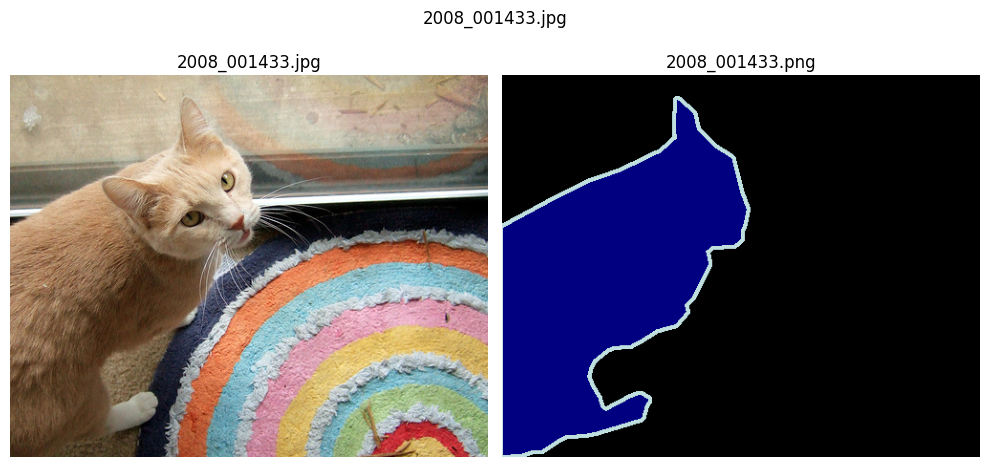

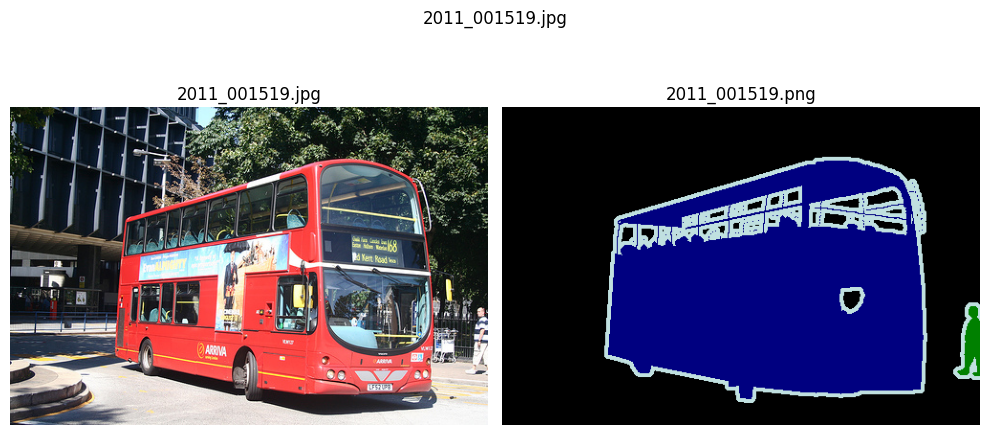

In [3]:
# Get Random VOC image
voc_img, voc_seg, voc_id = get_random_voc_img(voc_img_dir, voc_ins_seg, plot_true=True)

# Get VOC (id) image
voc_id = '2011_001519'
voc_img, voc_seg, voc_id = get_voc_img(voc_id, voc_img_dir, voc_ins_seg, plot_true=True)

### Select Fashinpedia image/segmentation


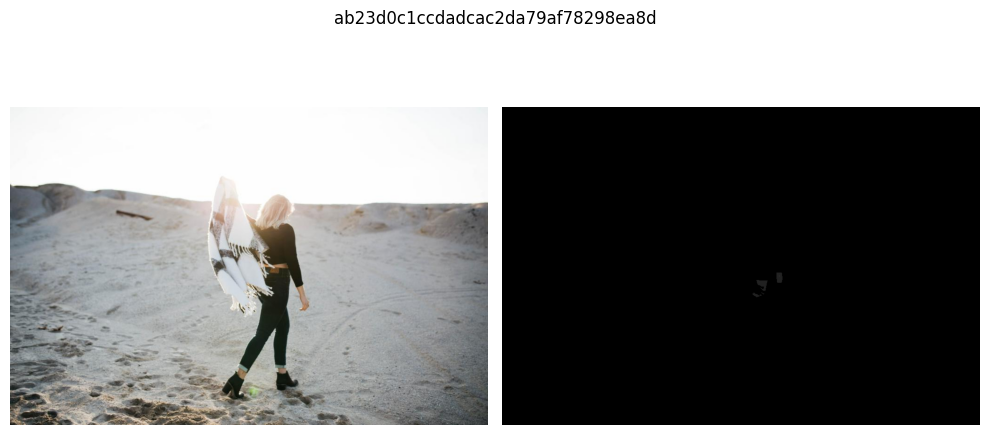

In [110]:
# 0. Select Fashion image/segmentation
# img_id = "8a20effd8b6ebcaf2b74caa7d35eee41"
# img_id = "0a3e75ac695e2a5673c9d1e1356e14a2"

tar_img, tar_seg = get_fashion_img_seg(img_id, fashion_img_dir, fashion_seg_dir, plot=True)

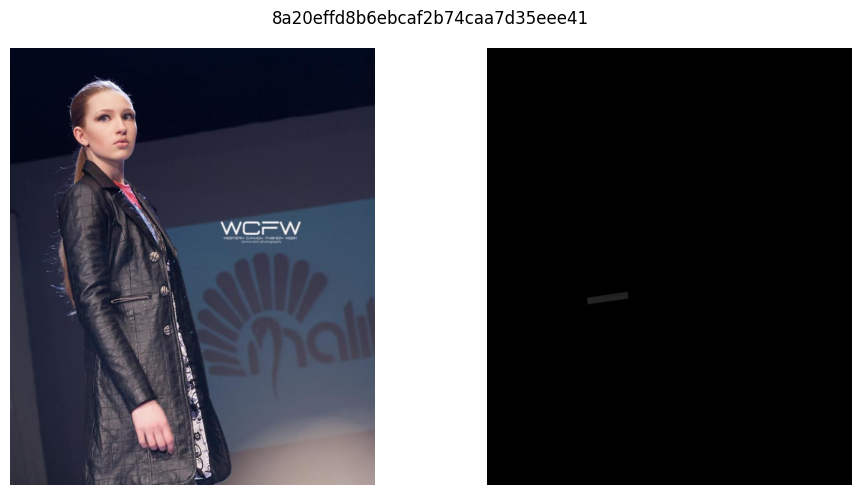

In [77]:
# 0. Select Fashion image/segmentation
img_id = "8a20effd8b6ebcaf2b74caa7d35eee41"
# img_id = "0a3e75ac695e2a5673c9d1e1356e14a2"

tar_img, tar_seg = get_fashion_img_seg(img_id, fashion_img_dir, fashion_seg_dir, plot=True)

## Task 3 - Data Augmentation

0. Select Fashion image/segmentation
1. Select VOC Image/Segmentation
2. Select Instance + Region
3. Insert VOC instance into Fashion image
   - Select random position
   - (optional) resize VOC instance
   - (optional) random rotation
   - Insert into fashion image
4. Arange Fashion segmentation



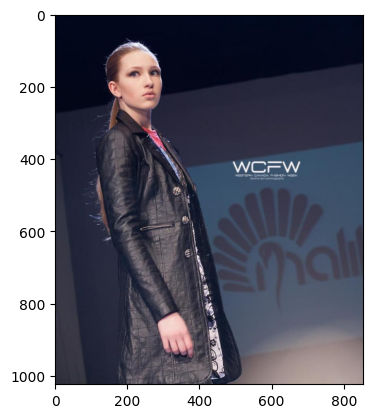

In [13]:
from utils.draw import imshow
imshow(imgs[0], axis_off=False)

In [51]:
cv2.imwrite("prova.png", im_seg)

# Read image
img = cv2.imread("prova.png")

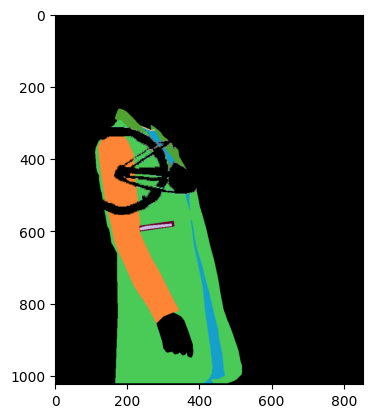

In [71]:
plt.imshow(mask_to_3D(img, palette))

12:12:26.562 Get Fashion image/segmentation, shape: (1024, 853, 3)
12:12:26.575 Get VOC image/segmentation, shape: (375, 500, 3)
12:12:26.575 Filter VOC instance
12:12:26.697 bbox: (151, 81, 338, 400) h: 187 w: 319
12:12:26.697 Resize factor: 5.475935828877005 2.6739811912225706 2.1391849529780567
12:12:26.697 Crop/Resize VOC instance(375, 500, 3)
12:12:26.697 Crop/Resize VOC instance(400, 682, 3)
(1024, 853, 3)
(1024, 853, 3)
(375, 500, 3)
(375, 500, 3)
(1024, 853, 3)
(1024, 853, 3)


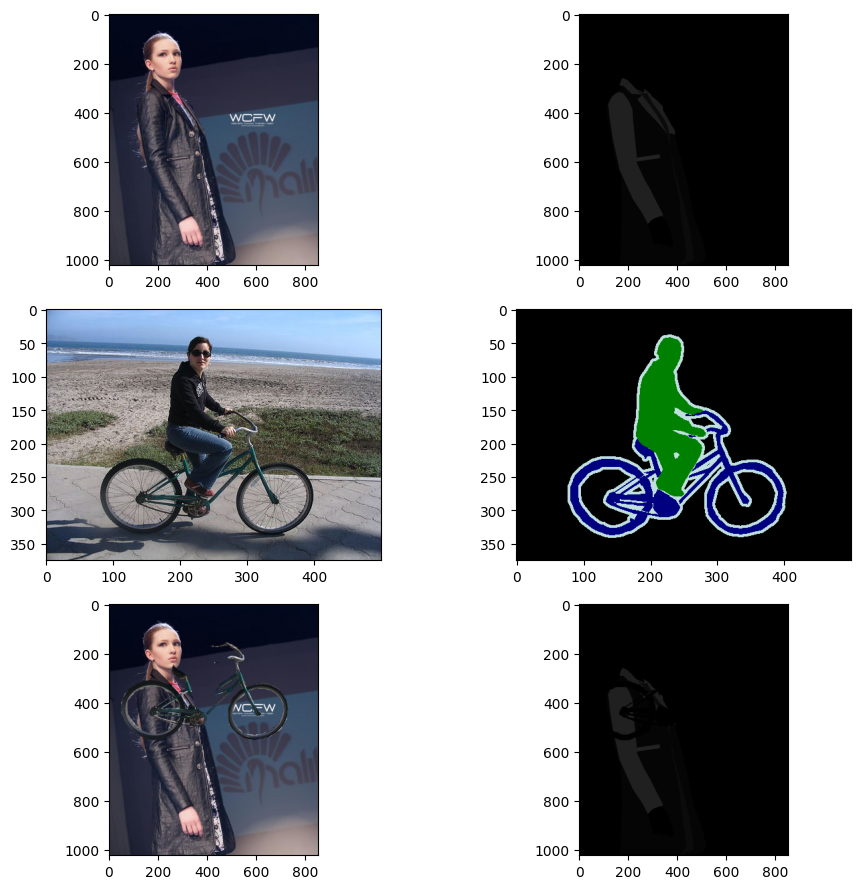

In [33]:
imgs = voc_data_augmentation(tar_img, tar_seg, voc_img_dir, voc_ins_seg, cover_factor=0.8)
imshow_many(imgs, cols=2, rows=3, axis_off=False)

11:44:35.981 Get Fashion image/segmentation, shape: (1024, 853, 3)
11:44:35.990 Get VOC image/segmentation, shape: (500, 500, 3)
11:44:35.990 Filter VOC instance
11:44:36.153 bbox: (69, 0, 493, 330) h: 424 w: 330
11:44:36.154 Resize factor: 2.4150943396226414 2.584848484848485 1.9320754716981132
11:44:36.154 Crop/Resize VOC instance(500, 500, 3)
11:44:36.154 Crop/Resize VOC instance(819, 637, 3)


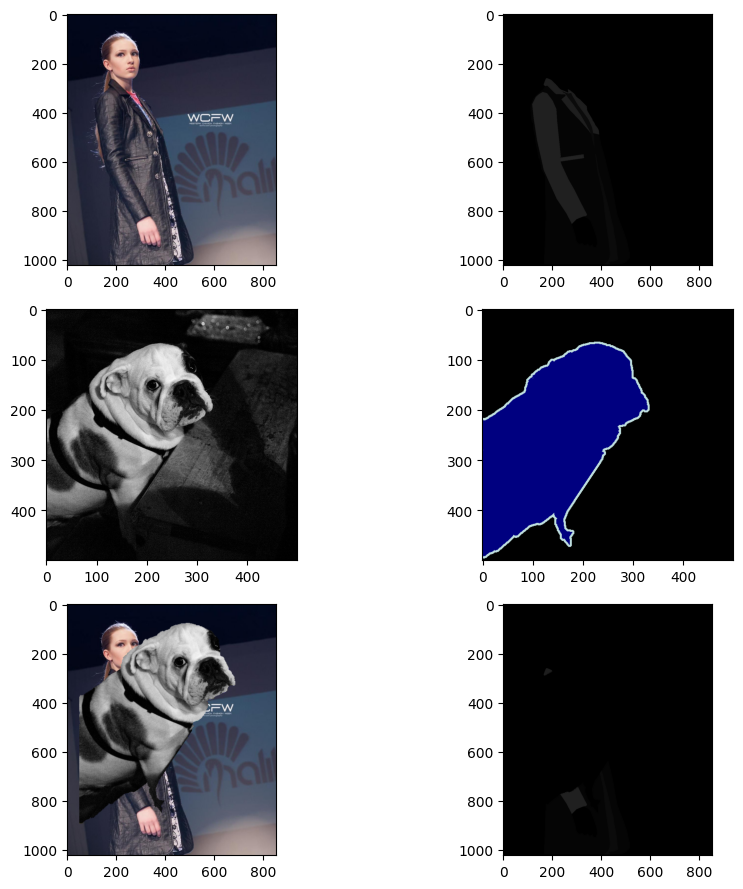

In [32]:
imgs = voc_data_augmentation(tar_img, tar_seg, voc_img_dir, voc_ins_seg, cover_factor=0.8)
imshow_many(imgs, cols=2, rows=3, axis_off=False)

### Task 3 - Data Augmentation (step by step)



13:40:11.130 Get Fashion image/segmentation, shape: (1024, 853, 3)
13:40:11.133 Get VOC image/segmentation, shape: (375, 500, 3)
13:40:11.133 Filter VOC instance
13:40:11.255 Crop/Resize VOC instance(233, 682, 3)
13:40:11.258 Plot
13:40:11.481 Finish


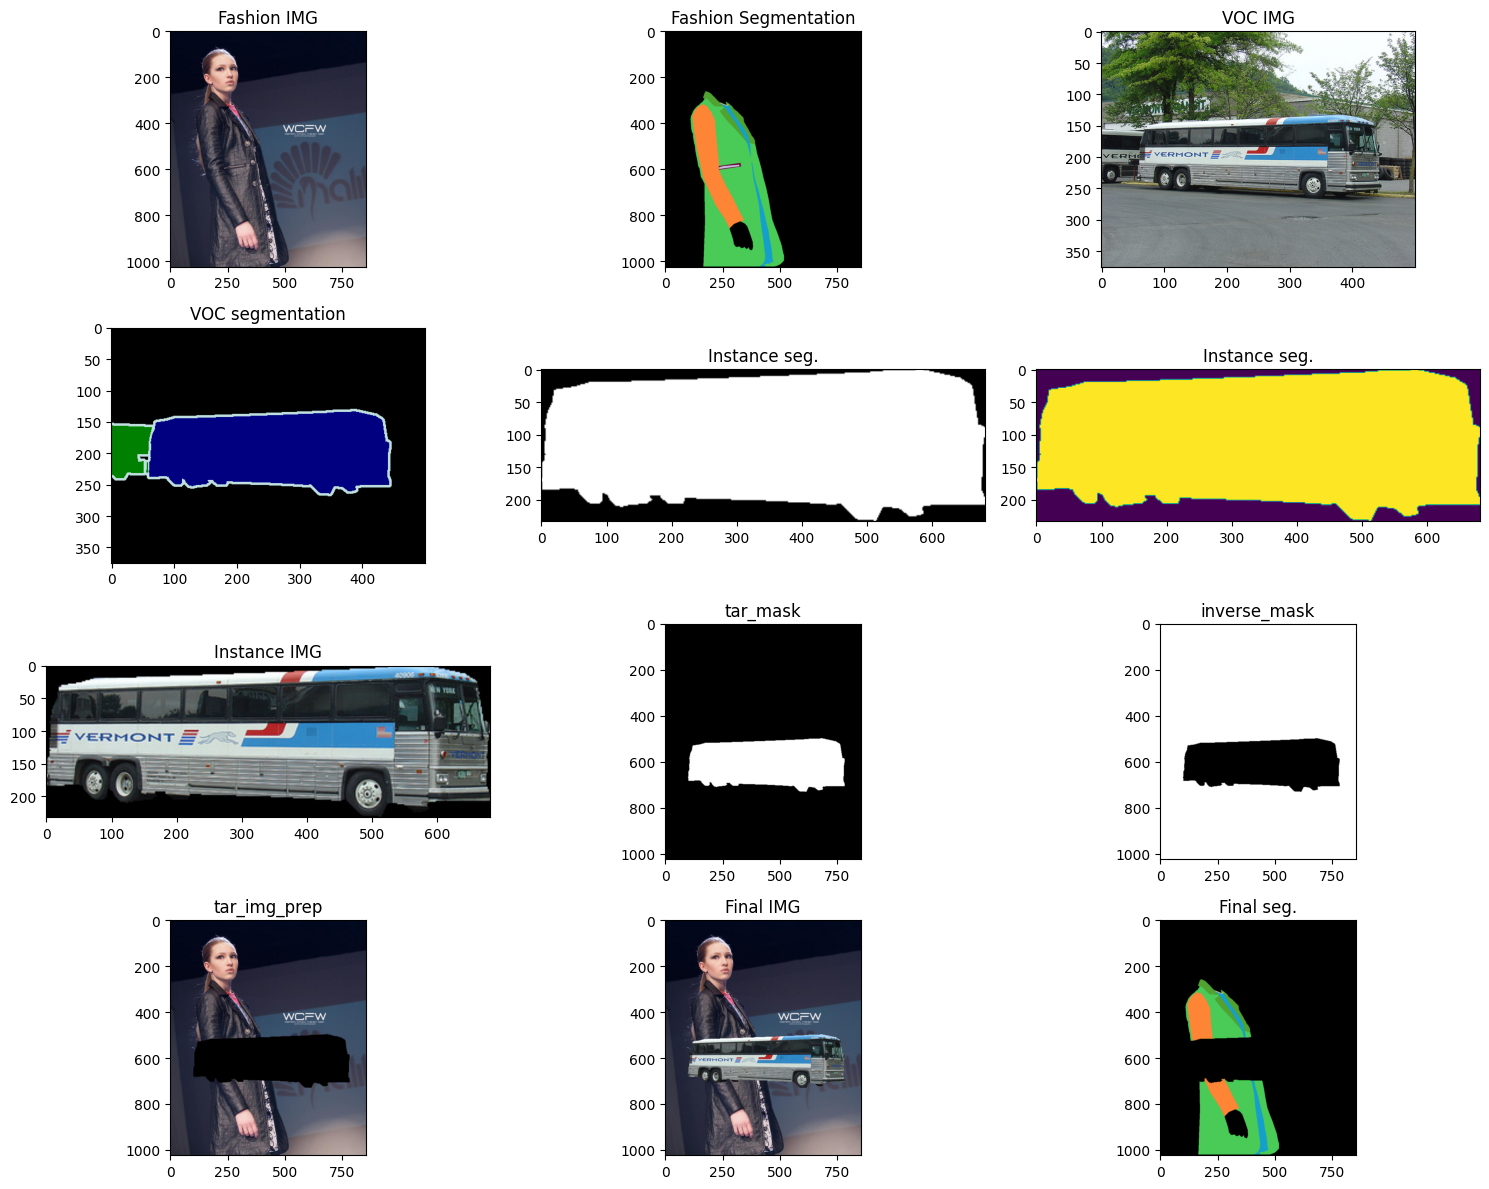

In [38]:

voc_bike, voc_monitors, voc_many = "2008_004995", "2007_007196", "2011_001530"  # => voc_chairs = '2008_007194' with something weird?

voc_bus = '2008_003373'
voc_horse = '2008_002762'


# ====================================================================================================
# 0. Select Fashion image/segmentation
img_id = "8a20effd8b6ebcaf2b74caa7d35eee41"
# img_id = "0a3e75ac695e2a5673c9d1e1356e14a2"

tar_img, tar_seg = get_fashion_img_seg(img_id, fashion_img_dir, fashion_seg_dir)
tar_shape = tar_seg.shape
log("Get Fashion image/segmentation, shape: "+ str(tar_shape))

# ====================================================================================================
# 1. Relect VOC and segmentation IMGs
voc_bike, voc_monitors, voc_many = "2008_004995", "2007_007196", "2011_001530"  # => voc_chairs = '2008_007194' with something weird?

voc_bus = '2008_003373'
voc_horse = '2008_002762'
voc_img, voc_seg, voc_id = get_voc_img(voc_bus, voc_img_dir, voc_ins_seg)


sou_img, sou_seg = voc_img, voc_seg

log("Get VOC image/segmentation, shape: " + str(sou_seg.shape))
# ====================================================================================================

# 2. Select Instance + Region
log("Filter VOC instance")
ins_seg = filter_color(sou_seg, filter_color=(255,255,255))
ins_seg_gray = cv2.cvtColor(ins_seg, cv2.COLOR_BGR2GRAY)

ins_img = sou_img.copy() # => No need to copy in production, just for testing
ins_img[~ins_seg_gray > 0] = [0,0,0]


# - (optional) resize VOC instance
sou_bbox = regionprops(ins_seg_gray)[0].bbox

# Randomly define resize_factor
h, w = sou_bbox[2]-sou_bbox[0], sou_bbox[3]-sou_bbox[1]

fy = tar_shape[0] / h
fx = tar_shape[1] / w

resize_factor = min(fy, fx)*0.8 # => Cover 80% of the target image
dsize=(int(w*resize_factor), int(h*resize_factor))

ins_seg = crop_resize(ins_seg, sou_bbox, dsize)
ins_seg_gray = crop_resize(ins_seg_gray, sou_bbox, dsize)
ins_img = crop_resize(ins_img, sou_bbox, dsize)


log("Crop/Resize VOC instance" + str(ins_seg.shape))
# - (optional) random rotation (not implemented)

# ====================================================================================================

# 3. Insert VOC instance into Fashion image
# - Select random position


x, y = 100, 500
tar_mask = np.zeros_like(tar_img)
h,w = ins_seg.shape[:2]
tar_mask[y:y+h, x:x+w] = ins_seg
inverse_mask = cv2.bitwise_not(tar_mask)

# ====================================================================================================

tar_img_prep = cv2.bitwise_and(tar_img, inverse_mask)
final_seg = cv2.bitwise_and(tar_seg, inverse_mask)
final_img = tar_img.copy()
final_img[y:y+h, x:x+w] = cv2.add(tar_img_prep[y:y+h, x:x+w], ins_img)


images = zip([tar_img, tar_seg, 
              sou_img, sou_seg, 
              ins_seg, ins_seg_gray, ins_img, tar_mask, inverse_mask, tar_img_prep, final_img, final_seg],
             ["Fashion IMG", "Fashion Segmentation", "VOC IMG", "VOC segmentation", 
              "Instance seg.", "Instance seg.", "Instance IMG", "tar_mask", "inverse_mask", "tar_img_prep", "Final IMG", "Final seg."])



log("Plot")
imshow_many(images, cols=3, rows=4, axis_off=False)
log("Finish")